In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

<h1>Preparando os dados</h1>

Dados em [UCI Repository](https://archive.ics.uci.edu/ml/datasets/Sales_Transactions_Dataset_Weekly). 

# este estudo é baseado no Workshop de Time-Series do curso do Mario Filho

In [2]:
data = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
# para esquecer das colunas normalizadas
data = data.filter(regex=r'Product|W')
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


# Usando a função melt do pandas para deixar o dataframe em um formato melhor.

In [3]:
melt = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

# regex para pegar somente os números do código do produto
melt['Product_Code'] = melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
# regex para pegar somente os números da semana
melt['Week'] = melt['Week'].str.extract('(\d+)', expand=False).astype(int)

# ordenando os valores por semana e código do produto
melt = melt.sort_values(['Week', 'Product_Code'])
# dimensões do dataframe
print(melt.shape)
melt.head()

(42172, 3)


,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


# simples de variáveis simples

In [4]:
melt2 = melt.copy()
# o argumento default de shift é 1
# vendas da última semana por produto: pegando as vendas da última semana
melt2['Sales_Ultima_Semana'] = melt2.groupby(['Product_Code'])['Sales'].shift(1)
# vendas da última semana por produto: pegando a diferença das vendas da última semana
melt2['Diff_Sales_Ultima_Semana'] = melt2.groupby(['Product_Code'])['Sales_Ultima_Semana'].diff()
# tirando os dados que contém nan
# tirando os valores faltantes. temos poucos features
melt2 = melt2.dropna()
melt2.head()

,Product_Code,Week,Sales,Sales_Ultima_Semana,Diff_Sales_Ultima_Semana
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [5]:
melt2['Week'].value_counts().sort_values()

31    811
14    811
29    811
28    811
27    811
26    811
25    811
24    811
23    811
22    811
21    811
20    811
51    811
19    811
50    811
18    811
49    811
17    811
48    811
16    811
47    811
15    811
45    811
13    811
44    811
33    811
7     811
12    811
43    811
11    811
42    811
10    811
41    811
9     811
40    811
8     811
46    811
39    811
30    811
6     811
37    811
5     811
36    811
4     811
35    811
3     811
34    811
2     811
38    811
32    811
Name: Week, dtype: int64

# Os valores de venda para cada semana são igualmente distribuídos! 

# Baseline e Validação: obtendo um resultado simples

In [6]:
# root mean squared log error metrics
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# baseline simples usando o valor da semana a ser previsto como sendo o valor da semana anterior!

In [7]:
mean_error = []
for week in range(40,52):
    # treina nas semanas anteriores 
    train = melt2[melt2['Week'] < week]
    # valida na semana atual
    val = melt2[melt2['Week'] == week]
    
    p = val['Sales_Ultima_Semana'].values
    
    error = rmsle(val['Sales'].values, p)
    print('Semana %d - Erro %.5f' % (week, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Semana 40 - Erro 0.51952
Semana 41 - Erro 0.51691
Semana 42 - Erro 0.51026
Semana 43 - Erro 0.50792
Semana 44 - Erro 0.53409
Semana 45 - Erro 0.52347
Semana 46 - Erro 0.50018
Semana 47 - Erro 0.49138
Semana 48 - Erro 0.50585
Semana 49 - Erro 0.50547
Semana 50 - Erro 0.52220
Semana 51 - Erro 0.55242
Média Erro = 0.51581


In [8]:
# fazendo um histograma do número de vendas

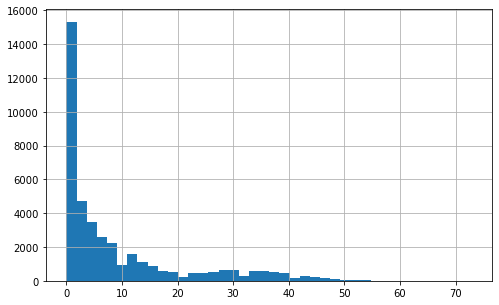

In [9]:
melt2['Sales'].hist(bins=40, figsize=(8,5))

# as vendas estão concentradas no intervalo 0-10

# Criando modelos interessantes!

In [10]:
melt4 = melt.copy()
melt4['Sales_Ultima_Semana'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Media_movel_1'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana'].rolling(1).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_Ultima_Semana'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana'].diff()
melt4['Sales_Ultima_Semana-1'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Media_movel_2'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-1'].rolling(2).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_Ultima_Semana-1'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-1'].diff()
melt4['Sales_Ultima_Semana-2'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Media_movel_3'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-2'].rolling(3).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_Ultima_Semana-2'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-2'].diff()
melt4 = melt4.dropna()
melt4.tail()

,Product_Code,Week,Sales,Sales_Ultima_Semana,Media_movel_1,Diff_Sales_Ultima_Semana,Sales_Ultima_Semana-1,Media_movel_2,Diff_Sales_Ultima_Semana-1,Sales_Ultima_Semana-2,Media_movel_3,Diff_Sales_Ultima_Semana-2
42167,815,51,0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.333333,-1.0
42168,816,51,5,6.0,6.0,1.0,5.0,5.0,0.0,5.0,4.666667,0.0
42169,817,51,3,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.666667,0.0
42170,818,51,0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.333333,0.0
42171,819,51,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [48]:

mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Semana %d - Erro %.5f' % (week, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Semana 40 - Erro 0.42007
Semana 41 - Erro 0.42680
Semana 42 - Erro 0.42025
Semana 43 - Erro 0.41694
Semana 44 - Erro 0.42772
Semana 45 - Erro 0.39780
Semana 46 - Erro 0.42112
Semana 47 - Erro 0.42974
Semana 48 - Erro 0.41538
Semana 49 - Erro 0.40337
Semana 50 - Erro 0.44168
Semana 51 - Erro 0.44709
Média Erro = 0.42233


# Modificando a função otimizada (e distribuição do alvo)

# temos valores mais uniformemente distribuídos

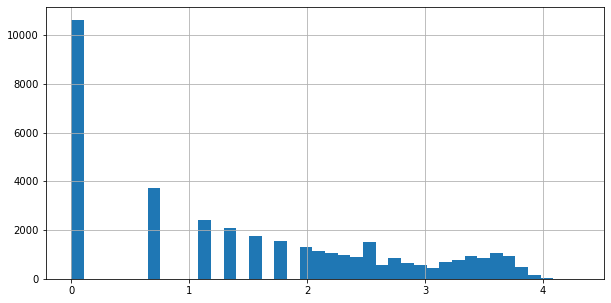

In [49]:
np.log1p(melt4['Sales']).hist(bins=40, figsize=(10,5))

# recalculando!

In [51]:

mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Week 40 - Error 0.40767
Week 41 - Error 0.40515
Week 42 - Error 0.40197
Week 43 - Error 0.39968
Week 44 - Error 0.41825
Week 45 - Error 0.38842
Week 46 - Error 0.41281
Week 47 - Error 0.39931
Week 48 - Error 0.40716
Week 49 - Error 0.40968
Week 50 - Error 0.43622
Week 51 - Error 0.46366
Média Erro = 0.41250


# engraçado, piorou muito nos últimas semanas!!!

# Um modelo mais sofisticado

In [58]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Semana %d - Erro %.5f' % (week, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Semana 40 - Erro 0.40073
Semana 41 - Erro 0.38563
Semana 42 - Erro 0.38627
Semana 43 - Erro 0.38782
Semana 44 - Erro 0.40600
Semana 45 - Erro 0.37642
Semana 46 - Erro 0.39674
Semana 47 - Erro 0.38189
Semana 48 - Erro 0.39265
Semana 49 - Erro 0.39501
Semana 50 - Erro 0.41345
Semana 51 - Erro 0.44514
Média Erro = 0.39731


# colocando o target como sqrt(x)

In [11]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.sqrt(ytr))
    
    p = (mdl.predict(xts))**2
    
    error = rmsle(yts, p)
    print('Semana %d - Erro %.5f' % (week, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Semana 40 - Erro 0.41173
Semana 41 - Erro 0.38888
Semana 42 - Erro 0.39358
Semana 43 - Erro 0.39307
Semana 44 - Erro 0.41669
Semana 45 - Erro 0.38529
Semana 46 - Erro 0.40727
Semana 47 - Erro 0.37940
Semana 48 - Erro 0.39922
Semana 49 - Erro 0.40028
Semana 50 - Erro 0.41889
Semana 51 - Erro 0.44841
Média Erro = 0.40356


# log para o target é melhor!

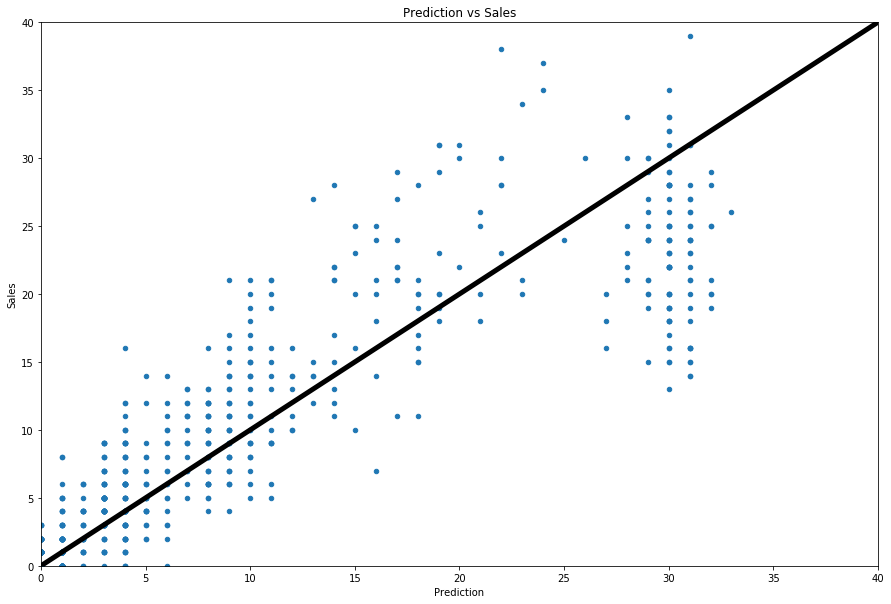

In [94]:
import matplotlib.pyplot as plt
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Sales', figsize=(15,10), title='Prediction vs Sales', 
                 ylim=(0,40), xlim=(0,40))

xx=[0,10,20,30,40]
yy=[0,10,20,30,40]
plt.plot(xx,yy,linewidth=5,color='black')

# o modelo está errando mais para vendas de 20 unidades.

In [85]:
sel.shape

(257,)

In [39]:
df_aux=melt.groupby(['Week'])['Sales'].sum()


In [43]:
#df_aux

In [32]:
melt.shape[0]

42172

In [36]:
melt['Week'][0]

0

In [44]:
df_aux=melt.groupby(['Week'])['Sales'].sum()
list_week=[]
for i in range(melt.shape[0]):
    week=melt['Week'][i]
    list_week.append(df_aux[week])
    


In [46]:
#list_week

In [54]:
melt4 = melt.copy()
melt4['Sales_Ultima_Semana'] = melt4.groupby(['Product_Code'])['Sales'].shift()
melt4['Media_movel_1'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana'].rolling(1).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_Ultima_Semana'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana'].diff()

#melt4['SalesperWeek']=melt4.groupby(['Week'])['Sales'].shift()
#melt4['PerweekMedia_movel_1'] = melt4.groupby(['Product_Code'])['SalesperWeek'].rolling(2).mean().reset_index(level=0, drop=True)
#melt4['Perweek_Diff_Sales_Ultima_Semana'] = melt4.groupby(['Product_Code'])['SalesperWeek'].diff()
df_aux=melt.groupby(['Week'])['Sales'].sum()
list_week=[]
for i in range(melt.shape[0]):
    week=melt['Week'][i]
    list_week.append(df_aux[week])
melt4['weekallsales']=list_week

melt4['weekallsales'] = melt4.groupby(['Week'])['weekallsales'].shift()
melt4['Media_movel_weeksales'] = melt4.groupby(['Week'])['weekallsales'].rolling(2).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_weekallsales'] = melt4.groupby(['Week'])['weekallsales'].diff()


melt4['Sales_Ultima_Semana-1'] = melt4.groupby(['Product_Code'])['Sales'].shift(2)
melt4['Media_movel_2'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-1'].rolling(2).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_Ultima_Semana-1'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-1'].diff()

#melt4['SalesperWeek_2']=melt4.groupby(['Week'])['Sales'].shift(2)
#melt4['PerweekMedia_movel_2'] = melt4.groupby(['Product_Code'])['SalesperWeek'].rolling(4).mean().reset_index(level=0, drop=True)
#melt4['Perweek_Diff_Sales_Ultima_Semana_2'] = melt4.groupby(['Product_Code'])['SalesperWeek'].diff()


melt4['weekallsales_2'] = melt4.groupby(['Week'])['weekallsales'].shift(2)
melt4['Media_movel_weeksales_2'] = melt4.groupby(['Week'])['weekallsales'].rolling(4).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_weekallsales_2'] = melt4.groupby(['Week'])['weekallsales'].diff(2)


melt4['Sales_Ultima_Semana-2'] = melt4.groupby(['Product_Code'])['Sales'].shift(3)
melt4['Media_movel_3'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-2'].rolling(3).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_Ultima_Semana-2'] = melt4.groupby(['Product_Code'])['Sales_Ultima_Semana-2'].diff()

melt4['weekallsales_3'] = melt4.groupby(['Week'])['weekallsales'].shift(3)
melt4['Media_movel_weeksales_3'] = melt4.groupby(['Week'])['weekallsales'].rolling(8).mean().reset_index(level=0, drop=True)
melt4['Diff_Sales_weekallsales_3'] = melt4.groupby(['Week'])['weekallsales'].diff(3)



melt4 = melt4.dropna()
melt4.tail()


#melt4['SalesperWeek_3']=melt4.groupby(['Week'])['Sales'].shift(3)
#melt4['PerweekMedia_movel_3'] = melt4.groupby(['Product_Code'])['SalesperWeek'].rolling(6).mean().reset_index(level=0, drop=True)
#melt4['Perweek_Diff_Sales_Ultima_Semana_3'] = melt4.groupby(['Product_Code'])['SalesperWeek'].diff()



,Product_Code,Week,Sales,Sales_Ultima_Semana,Media_movel_1,Diff_Sales_Ultima_Semana,weekallsales,Media_movel_weeksales,Diff_Sales_weekallsales,Sales_Ultima_Semana-1,...,Diff_Sales_Ultima_Semana-1,weekallsales_2,Media_movel_weeksales_2,Diff_Sales_weekallsales_2,Sales_Ultima_Semana-2,Media_movel_3,Diff_Sales_Ultima_Semana-2,weekallsales_3,Media_movel_weeksales_3,Diff_Sales_weekallsales_3
42167,815,51,0,2.0,2.0,2.0,7209.0,7209.0,0.0,0.0,...,0.0,7209.0,7209.0,0.0,0.0,0.333333,-1.0,7209.0,7209.0,0.0
42168,816,51,5,6.0,6.0,1.0,7209.0,7209.0,0.0,5.0,...,0.0,7209.0,7209.0,0.0,5.0,4.666667,0.0,7209.0,7209.0,0.0
42169,817,51,3,4.0,4.0,4.0,7209.0,7209.0,0.0,0.0,...,0.0,7209.0,7209.0,0.0,0.0,0.666667,0.0,7209.0,7209.0,0.0
42170,818,51,0,2.0,2.0,2.0,7209.0,7209.0,0.0,0.0,...,0.0,7209.0,7209.0,0.0,0.0,0.333333,0.0,7209.0,7209.0,0.0
42171,819,51,1,0.0,0.0,0.0,7209.0,7209.0,0.0,0.0,...,0.0,7209.0,7209.0,0.0,0.0,0.000000,0.0,7209.0,7209.0,0.0


In [60]:
mean_error = []
for week in range(40,52):
    train = melt4[melt4['Week'] < week]
    val = melt4[melt4['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Semana %d - Erro %.5f' % (week, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

Semana 40 - Erro 0.40137
Semana 41 - Erro 0.38608
Semana 42 - Erro 0.38729
Semana 43 - Erro 0.38751
Semana 44 - Erro 0.40707
Semana 45 - Erro 0.37430
Semana 46 - Erro 0.39651
Semana 47 - Erro 0.38039
Semana 48 - Erro 0.39163
Semana 49 - Erro 0.39334
Semana 50 - Erro 0.41228
Semana 51 - Erro 0.43789
Média Erro = 0.39631


In [61]:
melt

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8
...,...,...,...
42167,815,51,0
42168,816,51,5
42169,817,51,3
42170,818,51,0
